In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

# Bayesian statistics in action

We've seen the basics of Bayes law in the accompanying notes. A more general version of Bayes' original formulation of the law was in fact independently discovered in the early 1800s by Pierre Simon Laplace, who had not seen Bayes' posthumus publication.

Laplace applied his work on mathematical probabilities to the estimation of Saturn's mass; this was one of the first applications of Bayesian statistics and his result remains remarkably consistent with the present accepted value. 

In this notebook we will step through a Bayesian analysis of the very same measurement – however, for the sake of simplicity and retaining our focus on the statistics rather than the celestial mechanics, we will tackle a much simpler formulation of the problem than did Mr Laplace. 

We turn to the first measurement of Saturn's mass, undertaken by Sir Isaac Newton using Keplerian laws and measurements of Saturn's moon Titan: using the period and radius of Titan's orbit around Saturn, one can solve for the mass of Saturn.

## How did Newton calculate $M_{Saturn}$?

Kepler's third law states that for any object orbiting a primary, the ratio of the square of the object's orbital period ($T$) and the cube of the semi-major axis ($a$) is constant. For example, all planets orbiting the sun have the same value of $T^2/a^3$.

With knowledge of Newton's Law of Gravitation, this ratio can be expressed in terms of the mass of the central ($M$) and orbiting ($m$) objects:

$$\frac{a^3}{T^2} = \frac{G(M+m)}{4\pi^2}$$

In the case of Titan orbiting Saturn, without knowing the mass of either object, it is clear that $m_{Titan}<<M_{Saturn}$, and so our (and Newton's!) simplifying assumption is that the mass of Titan can be dropped from the equation entirely. In this case we can easily solve for $M_{Saturn}$ in terms of the period and semi-major axis of Titan's orbit around Saturn:

$$M_{Saturn} = \frac{4\pi^2 a^3}{GT^2}$$

## (Simulated) measurements of Titan

Sky and Telescope magazine have a [simulator](https://skyandtelescope.org/wp-content/plugins/observing-tools/saturn_moons/saturn.html) for the observed positions of the moons of Saturn at any calendar date/time. You can easily click through hours/days and see the path of the moons around the planet. 

Below, we will start by making our own simulated measurements of Titan's path around Saturn. From these 'observations' we will, using Bayesian inference, find the posterior probability for the period and semi-major axis of Titan's orbit. We will then be ready to estimate the mass of Saturn, using the posteriors for the orbital parameters.

## Some assumptions

We will assume that Titan's orbit around Saturn is circular (i.e. eccentrcity=0, a pretty good approximation). Titan's orbit is inclined relative to the Earth, at an angle roughly $i=25$ degrees, however, so the observed positions of Titan do trace out an ellipse.  

The separation between maximal points on Titan's orbit, as observed from Earth, is $0.8$ arcseconds. The semi-minor axis of the observed ellipsde is $0.8$ arcsec * sin $i$ $\approx 0.35$ arcsec.

Another assumption we will make about our simulated data is that our time piece is very accurate, so that our measurement errors on the position, which we take to be Gaussian, are dominant.

In [2]:
def observe_data(n_days=30, noise=True, n_pts=30, sigma=0.08):
    """Simulate observations of Titan's position as function of time.
    
    Inputs
    ======
    n_days : int
        over how many days to observe in total (default: 30)
    noise : bool
        add noise to observations? Set noise=False to return all the simulated positions (default: True)
    n_pts : int
        if noise==True, how many total datapoints to observe (default: 30)
    sigma : float
        sigma, in arcsec, of Gaussian noise to add to observed positions, if noise==True (default: 0.08)
    
    Returns
    =======
    t : array
        vector of observation times
    x_obs, y_obs : arrays of same length as t
        vector of x and y observations positions
    
    """
    # true values of amplitude and period
    a_x = 0.8
    b = np.sin(0.47) # converted inclination to radians
    a_y = a_x * b
    T = 15.95
    omega = 2*np.pi / T
    
    # vector of time of observations (max of two per night)
    t = np.linspace(0, n_days, 2*n_days) 
    
    # if simulating noisy data, do two things: 
    if noise: 
        # 1) randomly draw n_pts to observe from t, and 
        t = np.random.choice(t, replace=False, size=n_pts) 
        # 2) add gaussian noise of scale sigma to each data point
        noise_x, noise_y = np.random.normal(scale=sigma, size=(2,n_pts))
    else: 
        noise_x, noise_y = 0, 0
        
    x_obs = (a_x/2) * np.sin(t * omega) + noise_x
    y_obs = (a_y/2) * np.cos(t * omega) + noise_y
    
    # add a random orientation to the data, to simulate the orbit not being aligned with pixel coordinates?
    
    return t, x_obs, y_obs

## Plot simulated data

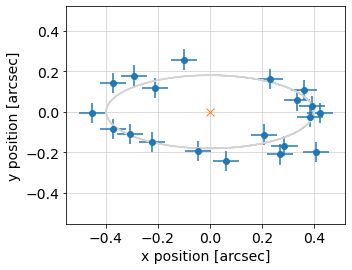

In [3]:
# draw noisy data:
xy_sigma_obs = .05
t_obs, x_obs, y_obs = observe_data(n_pts=20, n_days=40, sigma=xy_sigma_obs)
# draw noisless data, just for visualization purposes:
t_perf, x_perf, y_perf = observe_data(n_days=40, noise=False)

f, a1 = plt.subplots(1,1,figsize=(5,4))

a1.plot(x_perf, y_perf, color='lightgrey')
a1.errorbar(x_obs, y_obs, fmt='o', yerr=xy_sigma_obs, xerr=xy_sigma_obs)
a1.grid(color='lightgray', linestyle='-')
a1.plot(0, 0, 'x', ms=8)
a1.set_ylabel('y position [arcsec]')
a1.set_xlabel('x position [arcsec]')

# set x and y axis limits equal
a1.set_ylim(a1.get_xlim())
plt.show()

Above, we plot the measured position of Titan (blue) around Saturn (orange cross). The blue data points are noisy observations from the gray curve which represents the true, noiseless, orbit. 

In the wild, the image coordinates ($x$ and $y$, above) will not be aligned with the semi-major/semi-minor axis directions of the elliptical orbits. In this case, we would not be able to decompose our observations into components along these directions in order to model each component separately. However, we are able to calculate the distance of Titan from Saturn at each point in time, which is coordinate independent. We'll refer to this quanitity as $d_{TS}$.

In the figure below, we show $d_{TS}$ for each of the datapoints in the figure above, plotted as a function of time. Once again, the blue datapoints are noisy observations from the grey curve. 

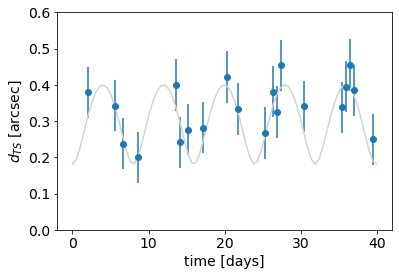

In [4]:
def measure_distance(x,y,sigma=None):
    """Given x and y coordinates, measure amplitude of motion."""
    if sigma is None:
        return np.sqrt(x**2 + y**2)
    else:
        return np.sqrt(x**2 + y**2), np.sqrt(2)*sigma

f, a2 = plt.subplots(1,1,figsize=(6,4))

a2.plot(t_perf, measure_distance(x_perf, y_perf), '-', color='lightgrey')

dts_obs, sigma_obs = measure_distance(x_obs, y_obs, xy_sigma_obs)
a2.errorbar(t_obs, dts_obs, yerr=sigma_obs, fmt='o')
a2.set_ylabel('$d_{TS}$ [arcsec]')
a2.set_xlabel('time [days]')
a2.set_ylim([0,.6])
plt.show()

## Steps for Bayesian inference

We now have data ready to go – what next? The statistics problem we face is to take these noisy measurements of $d_{TS}$ and infer the orbital parameters governing the motion of Titan. 

There are a series of basic steps, outlined here, which are a rough guide to solving any inference problem:

1. write down a model and assumptions about the data/problem
2. write down a likelihood
3. choose a prior
4. use some method to find explore the posterior
5. quantify parameter estimates and uncertainties from the posterior

In many problems you might see later in your Bayesian career, step 4 might involve methods like Markov Chain Monte Carlo to sample possible values in parameter space and calculate the associated posterior. Here, we'll use a simple grid over parameter space – something which would rapidly become computationally infeasible for larger or more complex parameter spaces. 

## 1. Model the observed amplitude as function of time

This Saturn-Titan distance, $d_{TS}$, can be modeled as a combination of sine and cosine waves with period $T$, and amplitudes given by the maximum separation distance $a$ and the inclination angle $i$ of the system: 
$$d_{TS}(a, T, t) = \frac{a}{2} \left[ \left(\sin^2(2\pi t / T)+\sin^2i\cos^2(2\pi t / T) \right)\right]^{1/2}$$

(Most generally we'd have a phase floating around in the sine and cosine that we would need to fit as well. We've cheated a bit and held it fixed in our simulations, to simplify the number of free parameters for this example.)

Note that if we were seeing this system face on, we would set $\sin i=1$ and we would have a constant separation $a/2$ at all times $t$. Similarly, for an edge-on system, we set $\sin i=0$ and as a result would see the planet move sinusoidally along a line. Note that we could constrain this inclination angle, as well as the other orbital parameters, but will keep it fixed for simplicity.

The above function for $d_{TS}$ gives us the Saturn-Titan distance, provided a value of semi-major axis $a$ and period $T$ of the orbit, for a set of times $t_{obs}$. We will label $d_{obs}$ the observations of $d_{TS}$ taken at times $t_{obs}$ 

Our datapoints are thus $d_{obs}, t_{obs}$ and our model parameters of interest are $a$ and $T$. 

## 2. Likelihood
We will use $d_{TS}$ (coded below) in the likelihood for our analysis; for each set of parameters values $(a,T)$, the predictions of $d_{TS}(a,T,t_{obs})$ will be compared to our observed values $d_{obs}$.

More specifically, we will use a Gaussian likelihood, under the assumption that the errors on our position measurements are normal:
$$p(d_{obs}|a,T,t_{obs}) = \mathcal{N}\left(d_{obs} - d_{TS}(a, T, t_{obs}),\sigma \right)$$

Note that we often deal with likelihoods, priors, and posteriors in log space for numerical reasons, because of frequent very small numbers.

In [5]:
def distance_TS(a, T, t):
    """Predict the Saturn-Titan distance at time t, given parameters a,T."""
    b = np.sin(0.47)
    w = 2*np.pi/T
    return a/2 * np.sqrt(np.sin(w*t)**2 + b**2 * np.cos(w*t)**2)

def log_likelihood(data, model, a, T, t, sigma):
    """Log likelihood of the data, given parameters a, T, sigma, and model for the data."""
    data = data[:,None,None]
    t = t[:,None,None]
    like_vector = -0.5 * np.log(2 * np.pi * sigma**2)  - (data - model(a, T, t))**2 / (2 * sigma)
    return np.sum(like_vector, axis=0)

## 3. Priors

Prior distributions encode what we already know about the parameters we will try to constrain in future steps of our analysis. 

In our case, we can come up with some reasonable guesses about possible values for Titan's period and orbital distance. Within some range of values, though, we don't necessarily know how to assign prior probability. Here, we will begin by using uniform prior distributions for both $a$ and $T$: note that this choice is _not_ "uninformative," as any choice of prior contributes information into our analysis. 

Below, we define a uniform prior function which can take arbitrary bounds, and returns the log probability of a given parameter value. Inside this function, we must always check whether the parameter value is within the prior bounds!

We also define a log posterior probability function, which simply adds the log prior and log likelihood.

In [6]:
def log_uniform_prior(param, bounds):
    const = 1 / (bounds[1] - bounds[0])
    log_p = np.ones(param.shape) * const

    # check for entries that are out of bounds: set those entries to -np.inf (log(0))
    oob = np.where((param<bounds[0])|(param>bounds[1]))
    log_p[oob] = -np.inf
    
    return log_p

def log_posterior(data, a, T, t, sigma):
    """log posterior probability function: simply add the log prior and log likelihood."""
    bounds_a = [0.1, 2]
    bounds_T = [2, 30]
    return log_uniform_prior(a, bounds_a) + log_uniform_prior(T, bounds_T)\
            + log_likelihood(data, distance_TS, a, T, t, sigma)

Here we will set some bounds for $a$ and $T$: these are guesses that seem reasonable to me based on what I know about Titan – feel free to tweak these later and see what happens to the results of the analysis with different bounds on the prior. Remember that any value outside these bounds will be considered by the above prior function as completely improbable (probability = 0).

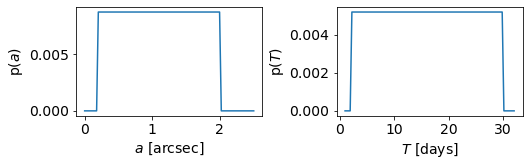

In [7]:
# set some min and max values for the parameter priors
Tmin, Tmax = 2, 30 # in days
amin, amax = 0.2, 2 # in arcsec

# get some a and T values to plot
T_vals = np.linspace(1, 32, 100)
a_vals = np.linspace(0, 2.5, 100)

# plot 
f, (a, T) = plt.subplots(1, 2, figsize=(8,2))

a.plot(a_vals, np.exp(log_uniform_prior(a_vals, [amin, amax]))/200)
a.set_xlabel('$a$ [arcsec]')
a.set_ylabel('p($a$)')

T.plot(T_vals, np.exp(log_uniform_prior(T_vals, [Tmin, Tmax]))/200)
T.set_xlabel('$T$ [days]')
T.set_ylabel('p($T$)')

plt.subplots_adjust(wspace=0.4)
plt.show()

## 4.I Calculating the posterior

We have all our functions and models set up now, and are ready to move on to the exciting part: calculating the posterior!
We'll construct a grid of points $(a,T)$, defined across the prior ranges, and calculate the posterior for each of these points.
With this grid, we will see what points in parameter space are most/least probable.

In [8]:
# set up the grid
n_grid = 200
T_vals = np.linspace(Tmin, Tmax, n_grid)
a_vals = np.linspace(amin, amax, n_grid)

T_grid, a_grid = np.meshgrid(T_vals, a_vals)

We calculate the distances $d_{obs}$ for the data points 'observed' above, and calculate the posterior probability of $a$, $T$ given those data. 

In [9]:
# find d_obs, given the x/y points observed at the top of this notebook.
d_obs = measure_distance(x_obs,y_obs)

# calculate the posterior on the grid points defined above
posterior = np.exp(log_posterior(d_obs, a_grid, T_grid, t_obs, sigma_obs))
# normalize the posterior (ok to do, since we set the probability to 0 outside this region)
posterior /= np.sum(posterior)

# marginalize over T and a to find the 1D posteriors for a and T:
posterior_a = np.sum(posterior, axis=1)
posterior_T = np.sum(posterior, axis=0)

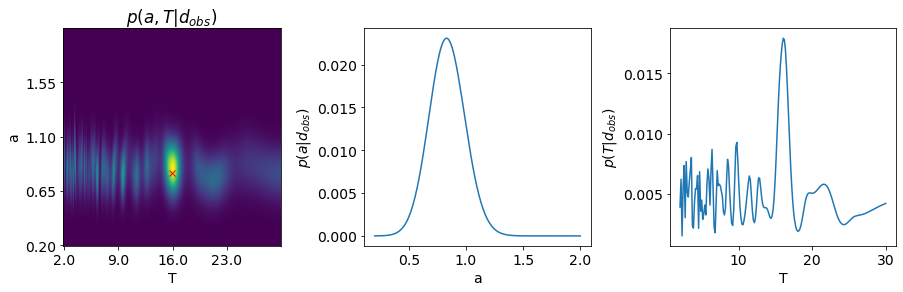

In [26]:
f, (a1, a2, a3) = plt.subplots(1, 3 ,figsize=(15, 4))

a1.imshow(posterior,origin='lower',)
a1.set_ylabel('a')
a1.set_xlabel('T')
a1.plot((15.95-Tmin) / (Tmax-Tmin) * n_grid, (0.8-amin) / (amax-amin) * n_grid, 'rx')
a1.set_title('$p(a,T|d_{obs})$')

a2.plot(a_vals, posterior_a)
a2.set_xlabel('a')
a2.set_ylabel('$p(a|d_{obs})$')

a3.plot(T_vals, posterior_T)
a3.set_xlabel('T')
a3.set_ylabel('$p(T|d_{obs})$')

ticks_loc = a1.get_yticks().tolist()
a1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
a1.set_yticklabels([f'{y * (amax-amin) / n_grid + amin:.2f}' for y in ticks_loc])
ticks_loc = a1.get_xticks().tolist()
a1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
a1.set_xticklabels([x * (Tmax-Tmin) / n_grid + Tmin for x in ticks_loc])

plt.subplots_adjust(wspace=.35)
plt.show()

On the left is the full posterior as a function of both variables $a$ and $T$. The red x shows the truth values that were used in the simulation. 

The right two panels show the marginalized posteriors, i.e. the posterior probability for one parameter at a time. The wiggles in $p(T|d_{obs})$, in the right panel, are a sampling effect due to the periodic nature of our data (think: aliasing in signal processing). These low probability peaks are related to harmonics of our data sampling frequency, nontrivial here given the random selection of data points. 

## 4.II posterior for $M_{Sat}$

This is all well and good, but what we really want is a value of Saturn's mass. So, how do we go from the posteriors on $a$ and $T$ to a posterior on mass?

This is fairly straightforward. According to the equations outlined at the beginning of this notebook, we can relate semi-major axis and period of an orbit to the mass of the central object. Thus, every point on the grid of (a,T) values also corresponds to a value of $M_{Sat}$.

We start below by defining a function to take $(a,T) \to M_{Sat}$, and then use it to convert each grid point to a mass. 

In [11]:
def calculate_saturn_mass(a, T):
    '''calculate saturn's mass using Newton's version of Kepler's third law'''
    a = a * 1.22e9/0.8
    G = 6.6743e-11 * (24*3600)**2
    num = 4 * np.pi**2 * a**3
    denom = G * T**2
    return num / denom

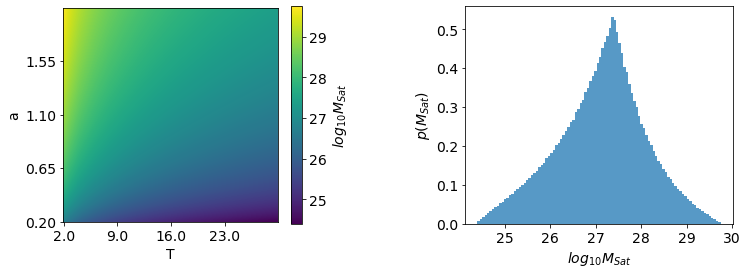

In [27]:
mass_grid = calculate_saturn_mass(a_grid, T_grid)

f, a = plt.subplots(1,2, figsize=(12,4))

# plot mass values of 2d grid
mcb = a[0].imshow(np.log10(mass_grid), origin='lower')
plt.colorbar(ax=a[0], mappable=mcb, label='$log_{10} M_{Sat}$')
a[0].set_xlabel('T')
a[0].set_ylabel('a')

# change ticks to a values
ticks_loc = a[0].get_yticks().tolist()
a[0].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
a[0].set_yticklabels([f'{y*(amax-amin)/n_grid + amin:.2f}' for y in ticks_loc])
# change ticks to T values
ticks_loc = a[0].get_xticks().tolist()
a[0].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
a[0].set_xticklabels([x*(Tmax-Tmin)/n_grid + Tmin for x in ticks_loc])

# plot effective prior
a[1].hist(np.log10(mass_grid.flatten()), bins=100, alpha=0.75, density=True)
a[1].set_xlabel('$log_{10} M_{Sat}$')
a[1].set_ylabel('$p(M_{Sat})$')

plt.subplots_adjust(wspace=.5)
plt.show()

On the left panel of this figure above, we display the 2D grid of $a, T$ with corresponding value of $M_{Sat}$ shown in color. 

In the right panel is shown the 1D histogram of mass values – this is the *effective prior* that we have placed on $M_{Sat}$. The choice of prior we made on $a$ and $T$ (both the choice of bounds, and how we assigned probability to the allowed values) result in the shape of this histogram. 

To find the posterior, we will weight each of these prior values by the associated likelihood value. See the plot below for the result. Note that the peak of the histogram has shift from the effective prior histogram above.

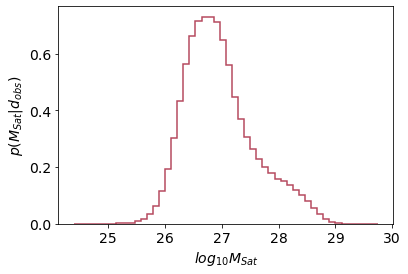

In [13]:
likelihood = np.exp( log_likelihood(d_obs, distance_TS, a_grid, T_grid, t_obs, sigma=sigma_obs) )

plt.hist(np.log10(mass_grid.flatten()), weights=likelihood.flatten(), bins=50, 
         density=True, histtype='step', color='#b5485d', linewidth=1.5);

plt.xlabel('$log_{10} M_{Sat}$')
plt.ylabel('$p(M_{Sat} | d_{obs})$')
plt.show();

## 5. Summarizing the posterior with credible intervals

Now that we have this nice posterior distribution, we want to report a single number (a "point estimate") with associated uncertainty ("credible interval") as a summary of our result. 

There are multiple valid ways to summarize a distribution in this way. Here we will use the mode of the posterior probability as our point estimate, and we will quote our uncertainty via the 1-$\sigma$ highest-density interval (HDI; this interval contains 1 $\sigma$ of the probability density, such that all points within the interval have higher probability than points outside it). Don't worry about the details of this definition, we will simply import a function to calculate it for us here. 

In [14]:
from credible import whist_ci

counts, edges = np.histogram(np.log10(mass_grid.flatten()), bins=50, 
                             weights=likelihood.flatten(), density=True);
centers = (edges[1:] + edges[:-1])/2

ci_dict = whist_ci({'x':centers, 'density':counts})

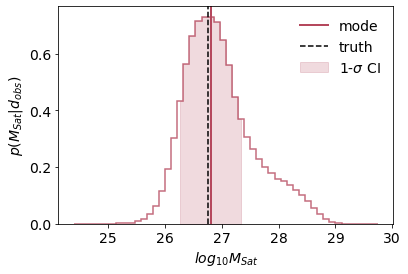

In [15]:
# plot the same posterior histogram as above.
plt.hist(np.log10(mass_grid.flatten()), weights=likelihood.flatten(), bins=50, 
         density=True, histtype='step', color='#b5485d', linewidth=1.5, alpha=0.8);

# shade in the 1-sigma confidence interval
plt.fill_between(centers, 0, counts, color='#b5485d', alpha=0.2, step='mid',
                 where=((centers>=ci_dict['min'][0]) & (centers<=ci_dict['max'][0])),
                 label='1-$\sigma$ CI')

# add in the mode and truth
plt.axvline(ci_dict['mode'], color='#b5485d', linestyle='-', linewidth=2, label='mode')
plt.axvline(np.log10(5.683e26), color='k', linestyle='--', label='truth')

plt.xlabel('$log_{10} M_{Sat}$')
plt.ylabel('$p(M_{Sat} | d_{obs})$')

plt.legend(frameon=False)
plt.show()

In [16]:
print(f"Estimated (log) mass of Saturn is: {ci_dict['mode']:.1f}, with 1-sigma CI: [{ci_dict['min'][0]:.1f},{ci_dict['max'][0]:.1f}]")
print(f"True (log) mass of Saturn: {np.log10(5.683e26):.1f}")

Estimated (log) mass of Saturn is: 26.8, with 1-sigma CI: [26.3,27.3]
True (log) mass of Saturn: 26.8


# Exercises
There are a number of assumptions we made in the above example. Feel free to make a copy of this notebook and try tweaking the analysis to see how it will change this result (or intermediate ones). 

For instance, here are two ideas of changes to explore:
- change the data sampling method (e.g. regularly spaced data, take data over fewer/more days, etc)
- change the priors (e.g. what happens with narrower/broader priors on $a$ and $T$? What about Gaussian priors (or anything else you want to try)? Can you come up with priors on $a$ and $T$ that will result in a uniform prior on $M_{Sat}$?)

## References:
- https://perfdynamics.blogspot.com/2013/09/laplace-bayesianista-and-mass-of-saturn.html
- http://www.dayofthenewdan.com/projects/astronomy-measure-titan-s-period/index.html
- https://medium.com/why-bother-with-space/how-do-we-know-the-mass-of-saturn-98fe3ce79632